# LIWC Test
*(Always to be run as sets up important env)*

In [1]:
!sed -i -e '/[<(]/d' dictionaries/LIWC07-EN.dic

In [2]:
import liwc
parse, category_names = liwc.load_token_parser('dictionaries/LIWC07-EN.dic')

In [22]:
import re
from collections import Counter

def tokenize(text):
    # you may want to use a smarter tokenizer
    for match in re.finditer(r'\w+', text, re.UNICODE):
        yield match.group(0)

def count_categories(text):
    # Returns a Counter object containing tallies of all LIWC categories
    text = text.lower()
    tokens = tokenize(text)
    counter = Counter(category for token in tokens for category in parse(token))

    # If a category doesn't exist in the text, we need to add it and set the count to 0
    for category in category_names:
        if category not in counter:
            counter[category] = 0

    return counter

gettysburg = "Hello"

print(count_categories(gettysburg))
#=> Counter({'funct': 58, 'pronoun': 18, 'cogmech': 17, ...})

Counter({'social': 1, 'funct': 0, 'pronoun': 0, 'ppron': 0, 'i': 0, 'we': 0, 'you': 0, 'shehe': 0, 'they': 0, 'ipron': 0, 'article': 0, 'verb': 0, 'auxverb': 0, 'past': 0, 'present': 0, 'future': 0, 'adverb': 0, 'preps': 0, 'conj': 0, 'negate': 0, 'quant': 0, 'number': 0, 'swear': 0, 'family': 0, 'friend': 0, 'humans': 0, 'affect': 0, 'posemo': 0, 'negemo': 0, 'anx': 0, 'anger': 0, 'sad': 0, 'cogmech': 0, 'insight': 0, 'cause': 0, 'discrep': 0, 'tentat': 0, 'certain': 0, 'inhib': 0, 'incl': 0, 'excl': 0, 'percept': 0, 'see': 0, 'hear': 0, 'feel': 0, 'bio': 0, 'body': 0, 'health': 0, 'sexual': 0, 'ingest': 0, 'relativ': 0, 'motion': 0, 'space': 0, 'time': 0, 'work': 0, 'achieve': 0, 'leisure': 0, 'home': 0, 'money': 0, 'relig': 0, 'death': 0, 'assent': 0, 'nonfl': 0, 'filler': 0})


# Text Analysis
Go through each entry in the text, and for each entry, add the following information:
- The publish utc timestamp of the comment/post
- The counter of the dimensions

The data structure to be returned will be a pandas dataframe, with the first column being the utc timestamp, and the second column is a counter of the dictionary of LIWC categories

E.g.: ```1000 | Counter({'social': 1...})]```

Everything will also get saved into a csv file after, first column is the utc timestamp, second column the dict

## Determine User Buckets

In [23]:
import tqdm
import pandas as pd
import json
import os


# Set the Reddit Data File Path (JSON)
data_file_path = "data/florida_comments.json"

time_interval_seconds = 2 * 30 * 24 * 60 * 60 # two months
time_start = 1546300801 # 1st January 2019
time_end = 1672531201 # 1st January 2023

activity_bucket_limits = [1, 10, 100, 1000, 10000, 100000, 1000000] # Inclusive on lower bound, exclusive on upper bound - strictly integers


# Group the users into buckets based on activity during each time interval
# Create a list of dictionaries the following format: (the index in the list is the time bucket index)
# [{user_id: posts_during_time_interval, user_id: posts_during_time_interval, ...}, 
#  {user_id: posts_during_time_interval, user_id: posts_during_time_interval, ...}, ...]

# Initialise a list of empty dictionaries of the amount of time intervals
activity_buckets = [{} for i in range(int((time_end - time_start) / time_interval_seconds) + 1)]

# Initialise progress bar
pbar = tqdm.tqdm(total=os.path.getsize(data_file_path))

# Iterate through the data file
with open(data_file_path) as data_file:
    # Analyse each line in the data file
    for line in data_file:
        # Load the line as a JSON object
        line_json = json.loads(line)
        
        # Get the timestamp of the comment
        timestamp = int(line_json["created_utc"])
        user_id = line_json["author"]

        # Check if within start and end time
        if timestamp < time_start or timestamp > time_end:
            # Update the progress bar
            pbar.update(len(line))
            continue
        
        # Get the time interval index
        time_interval_index = int((timestamp - time_start) / time_interval_seconds)

        # Check if the user has already been added to the activity bucket
        if user_id in activity_buckets[time_interval_index]:
            # Increment the user's post count
            activity_buckets[time_interval_index][user_id] += 1
        else:
            # Add the user to the activity bucket
            activity_buckets[time_interval_index][user_id] = 1

        # Update the progress bar
        pbar.update(len(line))

# Close the progress bar
pbar.close()

# Initialise another progress bar
pbar = tqdm.tqdm(total=len(activity_buckets))

# Change the activity count into bucket indices
for time_bucket in activity_buckets:
    # Update the progress bar
    pbar.update(1)
    for user in time_bucket:
        # Iterate through the activity bucket limits
        for i in range(len(activity_bucket_limits)):
            # Using the activity bucket limits, find the bucket index
            if time_bucket[user] >= activity_bucket_limits[i] and time_bucket[user] < activity_bucket_limits[i + 1]:
                # Set the activity bucket to the bucket index
                time_bucket[user] = i
                break


# Close the progress bar
pbar.close()

activity_buckets

  0%|          | 0/1613271037 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 100.51it/s]


[{'Miss_Awesomeness': 0,
  'GATORSUF052': 1,
  'pwnd3r': 0,
  'FrodaPB': 1,
  'jldude84': 1,
  'bbobbssagett': 0,
  'The_Mysterious_Mr_E': 0,
  'DieTheVillain': 0,
  'sass_pea': 0,
  'HairGelSwag': 0,
  'BritchStitcher': 0,
  '[deleted]': 2,
  'Ted-the-Pirate': 0,
  'uchiha_madara10': 0,
  'QuatroCincoMD': 0,
  'mrcanard': 0,
  'gn3xu5': 0,
  'agravain': 1,
  'sirtoodlesmcnoodles': 0,
  'IDontLikeOhio': 0,
  'INDYtoGNV': 0,
  'SgtCheeseNOLS': 1,
  'diacetyltrap': 1,
  'MiamiPower': 0,
  'laputa9': 1,
  'morethanso': 0,
  'sotosotosoto': 0,
  'Jhinkies': 0,
  'freshthrowaway1138': 1,
  'failstacksforfucks': 0,
  'ThisWasYourNightmare': 0,
  'CommanderMcBragg': 1,
  'imemeonyou3': 0,
  'Takai_Sensei': 0,
  'AVonGauss': 1,
  'GooieGui': 0,
  'RejectUF': 1,
  'Mikalton': 0,
  'RigBuild2016': 1,
  'kziv': 0,
  'UglyDuckling_20': 1,
  'WVJerry': 1,
  'mangroveassassin': 1,
  'burntsprinkle': 0,
  'sleazlybeasly': 0,
  'heroicdozer': 0,
  'Cronus6': 1,
  'stealthdawg': 0,
  'GuardingxCross': 

## Create CSV

In [24]:
run_CSV_creation = True

if run_CSV_creation:
    # Intialise the progress bar based on the number of items in the data file
    with open(data_file_path) as f:
        num_lines = sum(1 for line in f)

    pbar = tqdm.tqdm(total=num_lines)

    # Read the data file and add the data to the csv file
    with open(data_file_path) as f:
        with open(f'text_liwc_dimensions/{os.path.basename(data_file_path[:-5])}_LIWC.csv', 'w') as csv_file:

            # Clear the csv file of any existing data
            csv_file.truncate(0)

            for line in f:
                LIWC_by_bucket = json.loads(line)
                utc_timestamp = LIWC_by_bucket['created_utc']
                LIWC_categories = count_categories(LIWC_by_bucket['body'])
                author = LIWC_by_bucket['author']

                # Check if post is within the time interval
                if int(utc_timestamp) < time_start or int(utc_timestamp) > time_end:
                    pbar.update(1)
                    continue

                # Determine the activity bucket index
                time_interval_index = int((int(utc_timestamp) - time_start) / time_interval_seconds)
                activity_buckets_index = activity_buckets[time_interval_index][author]

                # Write the data to the csv file
                csv_file.write(f'{utc_timestamp},"{LIWC_categories}", {activity_buckets_index}\n')

                # Update the progress bar
                pbar.update(1)
            

    # Close the progress bar
    pbar.close()


100%|██████████| 1293082/1293082 [06:32<00:00, 3296.91it/s]


In [25]:
# Load the data from the csv file into a dataframe
df = pd.read_csv(f'text_liwc_dimensions/{os.path.basename(data_file_path[:-5])}_LIWC.csv')

# Add headers to the dataframe
df.columns = ['utc_timestamp', 'LIWC_categories', 'activity_bucket_index']

df.head()

,utc_timestamp,LIWC_categories,activity_bucket_index
0,1546301518,"Counter({'funct': 33, 'verb': 11, 'present': 1...",1
1,1546301651,"Counter({'funct': 7, 'pronoun': 3, 'verb': 3, ...",1
2,1546301940,"Counter({'funct': 90, 'cogmech': 29, 'pronoun'...",0
3,1546301963,"Counter({'assent': 1, 'funct': 1, 'article': 1...",1
4,1546302157,"Counter({'funct': 25, 'relativ': 11, 'cogmech'...",0


# Categorical Analysis
1. Analyse the makeup of categories of discourse over time intervals - think of a stacked bar graph.
2. Analyse the makeup of categories of discourse for each bucket of users - maybe over time intervals

## Makeup of Discourse

In [8]:
import numpy as np

# Calculate time bucket intervals
time_buckets = range(int(time_start), int(time_end) + int(time_interval_seconds), int(time_interval_seconds))

# Print maximum utc_timestamp
# print(df['utc_timestamp'].max())
# print("------------------")
# print(*time_buckets, sep='\n')


# Change the utc_timestamp to the bucket number, e.g. the 0th bucket is between the 0th index and the 1st index of the time_buckets
df['utc_timestamp'] = df['utc_timestamp'].apply(lambda x: np.searchsorted(time_buckets, x) - 1)


df.head()

,utc_timestamp,LIWC_categories,activity_bucket_index
0,0,"Counter({'funct': 5, 'pronoun': 3, 'affect': 2...",0
1,0,"Counter({'funct': 7, 'article': 3, 'cogmech': ...",0
2,0,"Counter({'funct': 8, 'pronoun': 3, 'ipron': 3,...",0
3,0,"Counter({'funct': 3, 'pronoun': 2, 'cogmech': ...",0
4,0,"Counter({'funct': 3, 'relativ': 2, 'adverb': 1...",0


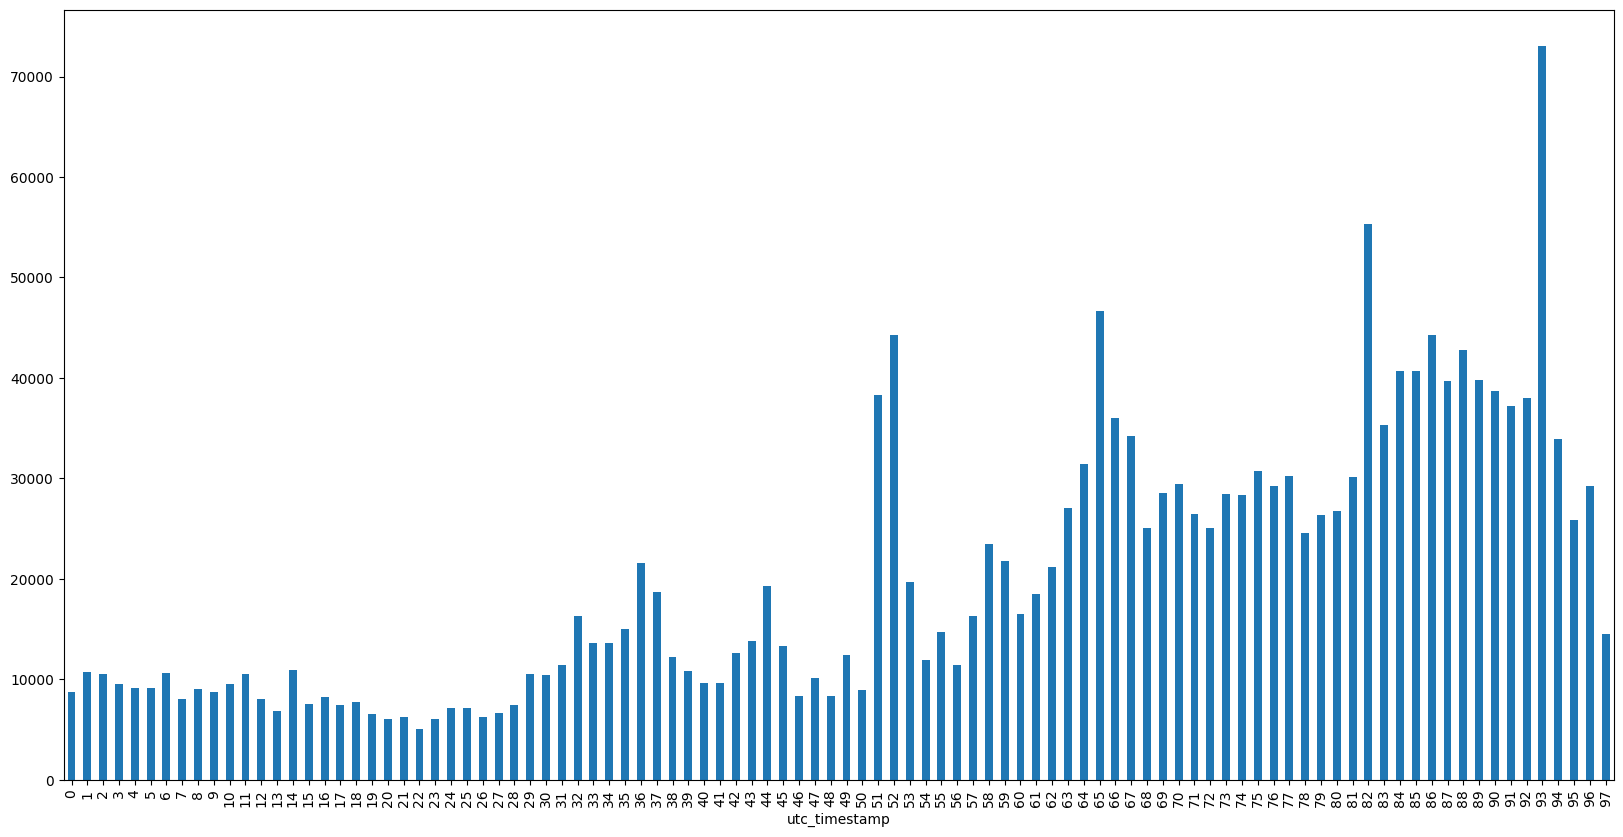

In [9]:
# Graph the number of comments per time bucket
import matplotlib.pyplot as plt

# Delete all rows with a utc_timestamp of -1
df = df[df['utc_timestamp'] != -1]

df['utc_timestamp'].value_counts().sort_index().plot(kind='bar', figsize=(20, 10))
plt.show()

In [10]:
run_aggregation = False

# The LIWC categories stored in a list
LIWC_by_bucket = [
    'funct', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they',
    'ipron', 'article', 'verb', 'auxverb', 'past', 'present', 'future',
    'adverb', 'preps', 'conj', 'negate', 'quant', 'number', 'swear',
    'social', 'family', 'friend', 'humans', 'affect', 'posemo',
    'negemo', 'anx', 'anger', 'sad', 'cogmech', 'insight', 'cause',
    'discrep', 'tentat', 'certain', 'inhib', 'incl', 'excl', 'percept',
    'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual', 'ingest',
    'relativ', 'motion', 'space', 'time', 'work', 'achieve', 'leisure',
    'home', 'money', 'relig', 'death', 'assent', 'nonfl', 'filler'
]

# Create a dataframe with the time_bucket and LIWC categories as the column headers
df_tb_liwc = pd.DataFrame(columns=['time_bucket'] + LIWC_by_bucket)

def get_time_bucket_counts(df):

    # Create a row of zeroes for each time_bucket, but time_bucket is the first column and is not a zero
    for i in range(len(time_buckets)):
        df_tb_liwc.loc[i] = [0 for n in range(len(LIWC_by_bucket) + 1)]
        df_tb_liwc.loc[i, 'time_bucket'] = i

    # Start a progress bar
    pbar = tqdm.tqdm(total=len(df))

    # Iterate through each entry in df and aggregate the LIWC categories for each time_bucket
    for index, row in df.iterrows():
        # Get the time_bucket and LIWC_categories
        time_bucket = row['utc_timestamp']
        LIWC_categories = row['LIWC_categories']

        # Convert the LIWC_categories string to a dictionary
        LIWC_categories = eval(LIWC_categories)

        # Add the time_bucket to the dictionary
        LIWC_categories['time_bucket'] = time_bucket

        # For each LIWC category in the dictionary, add the count to the correct time_bucket
        # Aggregate the LIWC category counts for the respective time_bucket
        # But dont sum the time_bucket column
        df_tb_liwc.loc[time_bucket] += pd.Series(LIWC_categories)
        df_tb_liwc.loc[time_bucket, 'time_bucket'] = time_bucket

        
        # Update the progress bar
        pbar.update(1)

    # Close the progress bar
    pbar.close()

    df_tb_liwc.head()

    # Save the dataframe to a csv file
    df_tb_liwc.to_csv(f'text_liwc_dimensions/{os.path.basename(data_file_path[:-5])}_LICW_aggregated.csv', index=False)

if run_aggregation:
    get_time_bucket_counts(df)


In [17]:
# Load the dataframe from the csv file
df_tb_liwc = pd.read_csv(f'text_liwc_dimensions/{os.path.basename(data_file_path[:-5])}_LICW_aggregated.csv')

df_tb_liwc.head()

,time_bucket,funct,pronoun,ppron,i,we,you,shehe,they,ipron,...,work,achieve,leisure,home,money,relig,death,assent,nonfl,filler
0,0,126859,32317,18405,6500,1957,5346,1519,3083,13912,...,5818,3853,2199,804,3427,682,549,1358,362,8
1,1,161146,41321,23888,8600,2067,7532,1732,3957,17433,...,7253,4528,2930,941,4677,1611,507,1671,413,9
2,2,163170,43740,25019,8477,2120,7973,2450,3999,18721,...,7211,4632,2511,798,3503,1258,639,1804,448,7
3,3,130985,33615,18953,7315,1646,5434,1439,3119,14662,...,5446,3915,2435,833,2541,752,480,1496,356,17
4,4,122019,30034,16897,6708,1680,4564,1426,2519,13137,...,4909,3338,2417,745,2565,614,534,1408,375,1


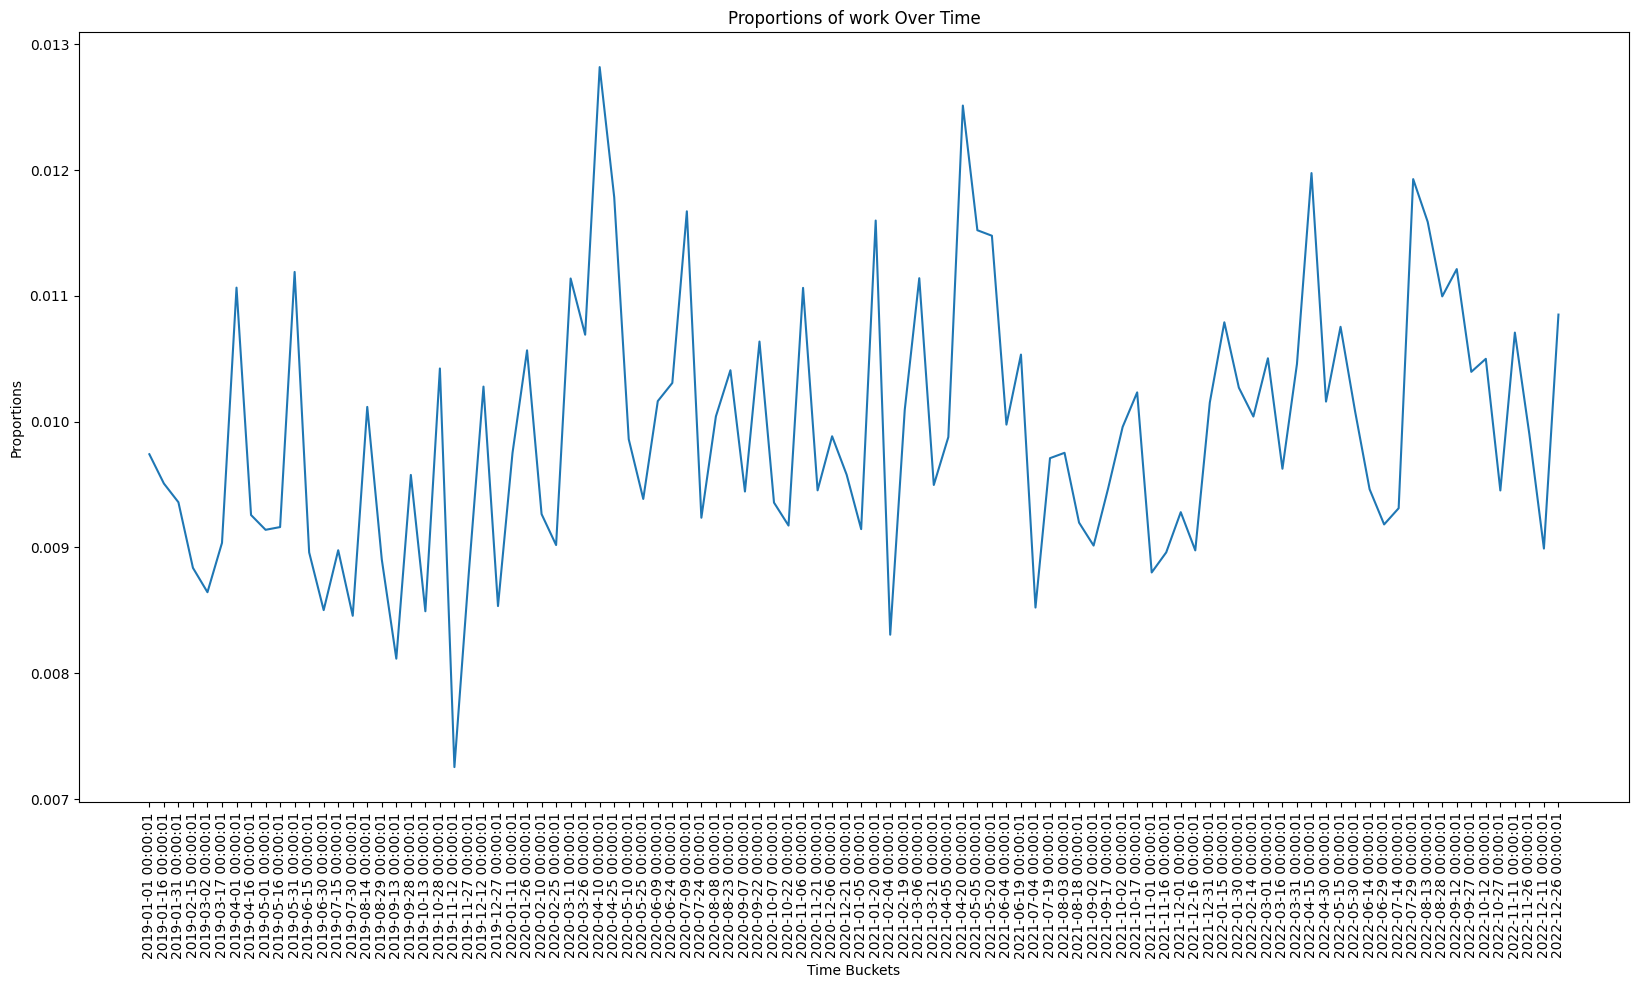

In [18]:
from datetime import datetime

# Choose a LIWC category to graph, and graph the proportion of that LIWC category per time_bucket

# The LIWC category to graph
category = 'work'

# Total number of detected LIWC category counts
# For each row, sum the entire row, but dont sum the time_bucket column, give a list of the sums
total_counts = df_tb_liwc.sum(axis=1).tolist()

# Get the number of words detected with the selected LIWC category
category_counts = df_tb_liwc[category].tolist()

# Divide the two lists to get the proportion of the selected LIWC category per time_bucket
proportions = [category_counts[i] / total_counts[i] for i in range(len(total_counts))]

# Specify the figure size
plt.figure(figsize=(20, 10))

# Make it a bar graph
plt.plot(time_buckets[:-1], proportions[:-1])

# Give time buckets human readable labels
plt.xticks(time_buckets[:-1], [datetime.utcfromtimestamp(time_bucket).strftime('%Y-%m-%d %H:%M:%S') for time_bucket in time_buckets[:-1]], rotation=90)

# Add labels and title
plt.xlabel('Time Buckets')
plt.ylabel('Proportions')
plt.title(f'Proportions of {category} Over Time')

# Display the graph
plt.show()

## Discourse Category by Bucket of Users

In [26]:
import numpy as np

# Calculate time bucket intervals
time_buckets = range(int(time_start), int(time_end) + int(time_interval_seconds), int(time_interval_seconds))

# Print maximum utc_timestamp
# print(df['utc_timestamp'].max())
# print("------------------")
# print(*time_buckets, sep='\n')


# Change the utc_timestamp to the bucket number, e.g. the 0th bucket is between the 0th index and the 1st index of the time_buckets
df['utc_timestamp'] = df['utc_timestamp'].apply(lambda x: np.searchsorted(time_buckets, x) - 1)


df.head()

,utc_timestamp,LIWC_categories,activity_bucket_index
0,0,"Counter({'funct': 33, 'verb': 11, 'present': 1...",1
1,0,"Counter({'funct': 7, 'pronoun': 3, 'verb': 3, ...",1
2,0,"Counter({'funct': 90, 'cogmech': 29, 'pronoun'...",0
3,0,"Counter({'assent': 1, 'funct': 1, 'article': 1...",1
4,0,"Counter({'funct': 25, 'relativ': 11, 'cogmech'...",0


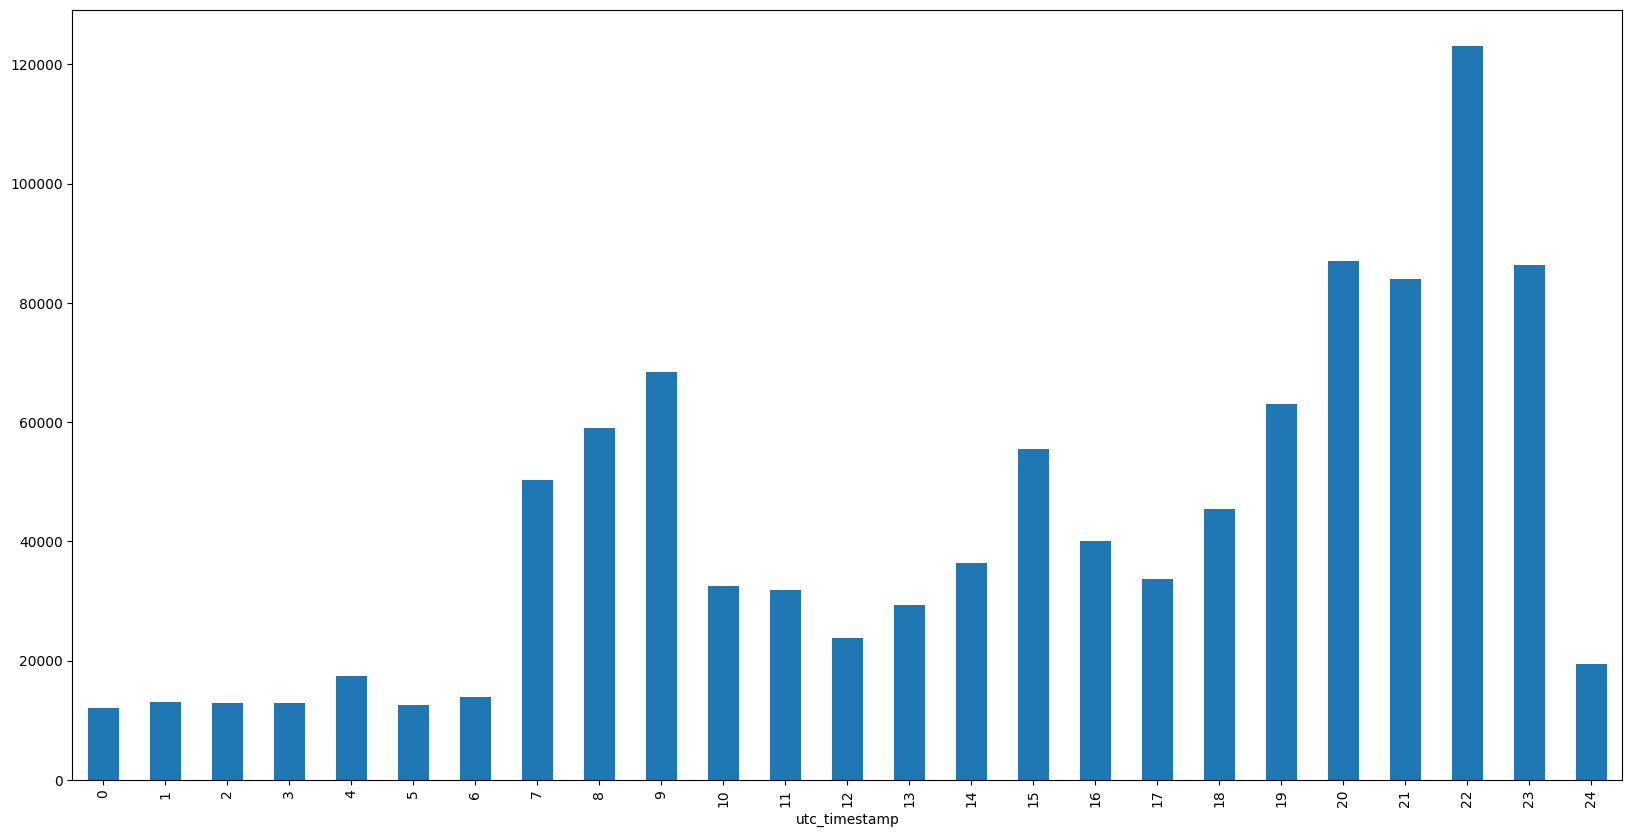

In [27]:
# Graph the number of comments per time bucket
import matplotlib.pyplot as plt

# Delete all rows with a utc_timestamp of -1
df = df[df['utc_timestamp'] != -1]

df['utc_timestamp'].value_counts().sort_index().plot(kind='bar', figsize=(20, 10))
plt.show()

In [28]:
# The LIWC categories stored in a list
data = [
    'funct', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they',
    'ipron', 'article', 'verb', 'auxverb', 'past', 'present', 'future',
    'adverb', 'preps', 'conj', 'negate', 'quant', 'number', 'swear',
    'social', 'family', 'friend', 'humans', 'affect', 'posemo',
    'negemo', 'anx', 'anger', 'sad', 'cogmech', 'insight', 'cause',
    'discrep', 'tentat', 'certain', 'inhib', 'incl', 'excl', 'percept',
    'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual', 'ingest',
    'relativ', 'motion', 'space', 'time', 'work', 'achieve', 'leisure',
    'home', 'money', 'relig', 'death', 'assent', 'nonfl', 'filler'
]

# Construct a dictionary with the value in the form of a nested list, and the key as the LIWC category
# where the outer index is the activity_bucket_index, and the inner index is the time_bucket_index
# {LIWC_category: [[time_bucket_0, time_bucket_1, ...], [time_bucket_0, time_bucket_1, ...], ...]}

# Initialise the dictionary
LIWC_category_dict = {}

# Initialise the dictionary with empty nested lists
LIWC_category_dict = {category: [[0 for _ in time_buckets] for _ in activity_bucket_limits] for category in data}

print(LIWC_category_dict)

# Start a progress bar
pbar = tqdm.tqdm(total=len(df))

# Iterate through each entry in df and aggregate the LIWC categories for each time_bucket
for index, row in df.iterrows():
    # Get the time_bucket and LIWC_categories
    time_bucket = row['utc_timestamp']
    LIWC_categories = row['LIWC_categories']
    activity_bucket_index = row['activity_bucket_index']

    # Convert the LIWC_categories string to a dictionary
    LIWC_categories = eval(LIWC_categories)

    # For each row, go through the LIWC categories and add the time_bucket to the correct list
    for category in LIWC_categories:
        LIWC_category_dict[category][activity_bucket_index][time_bucket] += (LIWC_categories[category])

    # Update the progress bar
    pbar.update(1)

# Close the progress bar
pbar.close()

LIWC_category_dict

{'funct': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'pronoun': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 

100%|██████████| 1063503/1063503 [11:21<00:00, 1560.31it/s]


{'funct': [[102953,
   108513,
   105839,
   107459,
   121091,
   99931,
   95671,
   282873,
   367892,
   362216,
   205166,
   212407,
   152039,
   195107,
   218937,
   294738,
   246974,
   221138,
   298926,
   344203,
   430251,
   452480,
   602242,
   443069,
   160225,
   0],
  [103234,
   98345,
   92072,
   78322,
   100330,
   79331,
   108633,
   402738,
   527222,
   554923,
   227914,
   200126,
   137591,
   196693,
   261790,
   380252,
   268012,
   229356,
   355609,
   487878,
   760321,
   660652,
   997943,
   641209,
   74826,
   0],
  [3665,
   1187,
   8120,
   11263,
   12950,
   9077,
   9306,
   152776,
   118519,
   210112,
   40484,
   49772,
   43675,
   56768,
   54796,
   89496,
   27461,
   18223,
   23657,
   133537,
   169834,
   169025,
   234642,
   96386,
   3701,
   0],
  [0,
   1920,
   3605,
   5908,
   4361,
   2954,
   5384,
   20347,
   68087,
   28903,
   24939,
   11625,
   7620,
   17340,
   20601,
   34370,
   17584,
   8117,
   16647

In [50]:
# Normalise the data by dividing each value by the total number of LIWC detected words in that activity and time bucket

# Get the sum of all the LIWC categories for each activity and time bucket in the form of a nested list, the outer index is the activity_bucket_index, and the inner index is the time_bucket_index
# [[time_bucket_0, time_bucket_1, ...], [time_bucket_0, time_bucket_1, ...], ...]

data = [
    'funct', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they',
    'ipron', 'article', 'verb', 'auxverb', 'past', 'present', 'future',
    'adverb', 'preps', 'conj', 'negate', 'quant', 'number', 'swear',
    'social', 'family', 'friend', 'humans', 'affect', 'posemo',
    'negemo', 'anx', 'anger', 'sad', 'cogmech', 'insight', 'cause',
    'discrep', 'tentat', 'certain', 'inhib', 'incl', 'excl', 'percept',
    'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual', 'ingest',
    'relativ', 'motion', 'space', 'time', 'work', 'achieve', 'leisure',
    'home', 'money', 'relig', 'death', 'assent', 'nonfl', 'filler'
]

LIWC_category_dict_normalised = LIWC_category_dict

LIWC_category_sums = [[0 for _ in time_buckets] for _ in activity_bucket_limits]

for activity_bucket_index in range(len(activity_bucket_limits)):
    for time_bucket_index in range(len(time_buckets)):
        # Sum the LIWC categories for each activity and time bucket
        LIWC_category_sums[activity_bucket_index][time_bucket_index] = sum(LIWC_category_dict[category][activity_bucket_index][time_bucket_index] for category in data)

print(LIWC_category_sums)

# Normalise the data by dividing each value by the total number of LIWC detected words in that activity and time bucket
for activity_bucket_index in range(len(activity_bucket_limits)):
    for time_bucket_index in range(len(time_buckets)):
        # Normalise the data
        # If sum is zero, set to zero, otherwise divide
        if LIWC_category_sums[activity_bucket_index][time_bucket_index] == 0:
            LIWC_category_dict_normalised[category][activity_bucket_index][time_bucket_index] = 0
        else:
            LIWC_category_dict_normalised[category][activity_bucket_index][time_bucket_index] /= LIWC_category_sums[activity_bucket_index][time_bucket_index]
            print(LIWC_category_dict_normalised[category][activity_bucket_index][time_bucket_index])



# Save LIWC_category_dict_normalised as a literal string to a file
with open(f'text_liwc_dimensions/{os.path.basename(data_file_path[:-5])}_LIWC_normalised.json', 'w') as f:
    f.write(str(LIWC_category_dict_normalised))

[[476786.0, 500905.0, 490189.00001006515, 499647.00001185766, 564298.0000017489, 465173.00000212144, 444594.0000088739, 1327016.0000022354, 1720025.000016098, 1701180.000006973, 957923.0000092748, 988179.0000059925, 705508.0, 906466.0000043551, 1022207.0000106198, 1376946.0000100385, 1155580.0000145265, 1032412.0000095555, 1398717.0000063528, 1612307.0000055144, 2005517.0000093547, 2108479.0000084303, 2812518.0000080788, 2062055.0000067053, 741348.0000119897, 0], [478863.0000020625, 454771.00000651425, 427012.0000023143, 361874.00002730836, 467051.0000126942, 368129.00000805524, 502654.0000098233, 1892083.0000146355, 2472045.0000088043, 2607129.0000128965, 1057072.000011218, 934256.0000042296, 638948.0000061793, 913041.0000032445, 1215697.0000089388, 1771263.0000094832, 1255276.0000125908, 1064418.000009282, 1656855.0000065607, 2283002.000007362, 3542310.000007532, 3081719.0000147447, 4645027.000010637, 2971559.0000073155, 345186.00000286225, 0], [17223.0, 5576.0, 36475.0, 51421.0, 588

[[6160, 6863, 6570, 6348, 7493, 6205, 6162, 15018, 19294, 19709, 12439, 13071, 9990, 11990, 13591, 17661, 14673, 14094, 17993, 19777, 25530, 26619, 34492, 25807, 9283, 0], [5991, 5753, 5084, 4304, 5599, 4295, 6336, 21033, 26749, 29182, 12629, 11459, 8368, 11597, 14883, 21382, 15471, 12910, 19789, 26114, 42438, 38043, 55554, 35621, 4187, 0], [193, 62, 336, 483, 688, 517, 385, 6740, 5427, 9616, 2372, 2707, 2417, 3067, 3184, 4807, 1583, 1331, 1236, 6920, 9005, 9134, 13227, 5500, 203, 0], [0, 113, 173, 277, 225, 154, 279, 1058, 2758, 1579, 1476, 715, 494, 1110, 1299, 2098, 981, 439, 965, 0, 0, 0, 0, 0, 28, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1455, 1437, 584, 795, 503, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


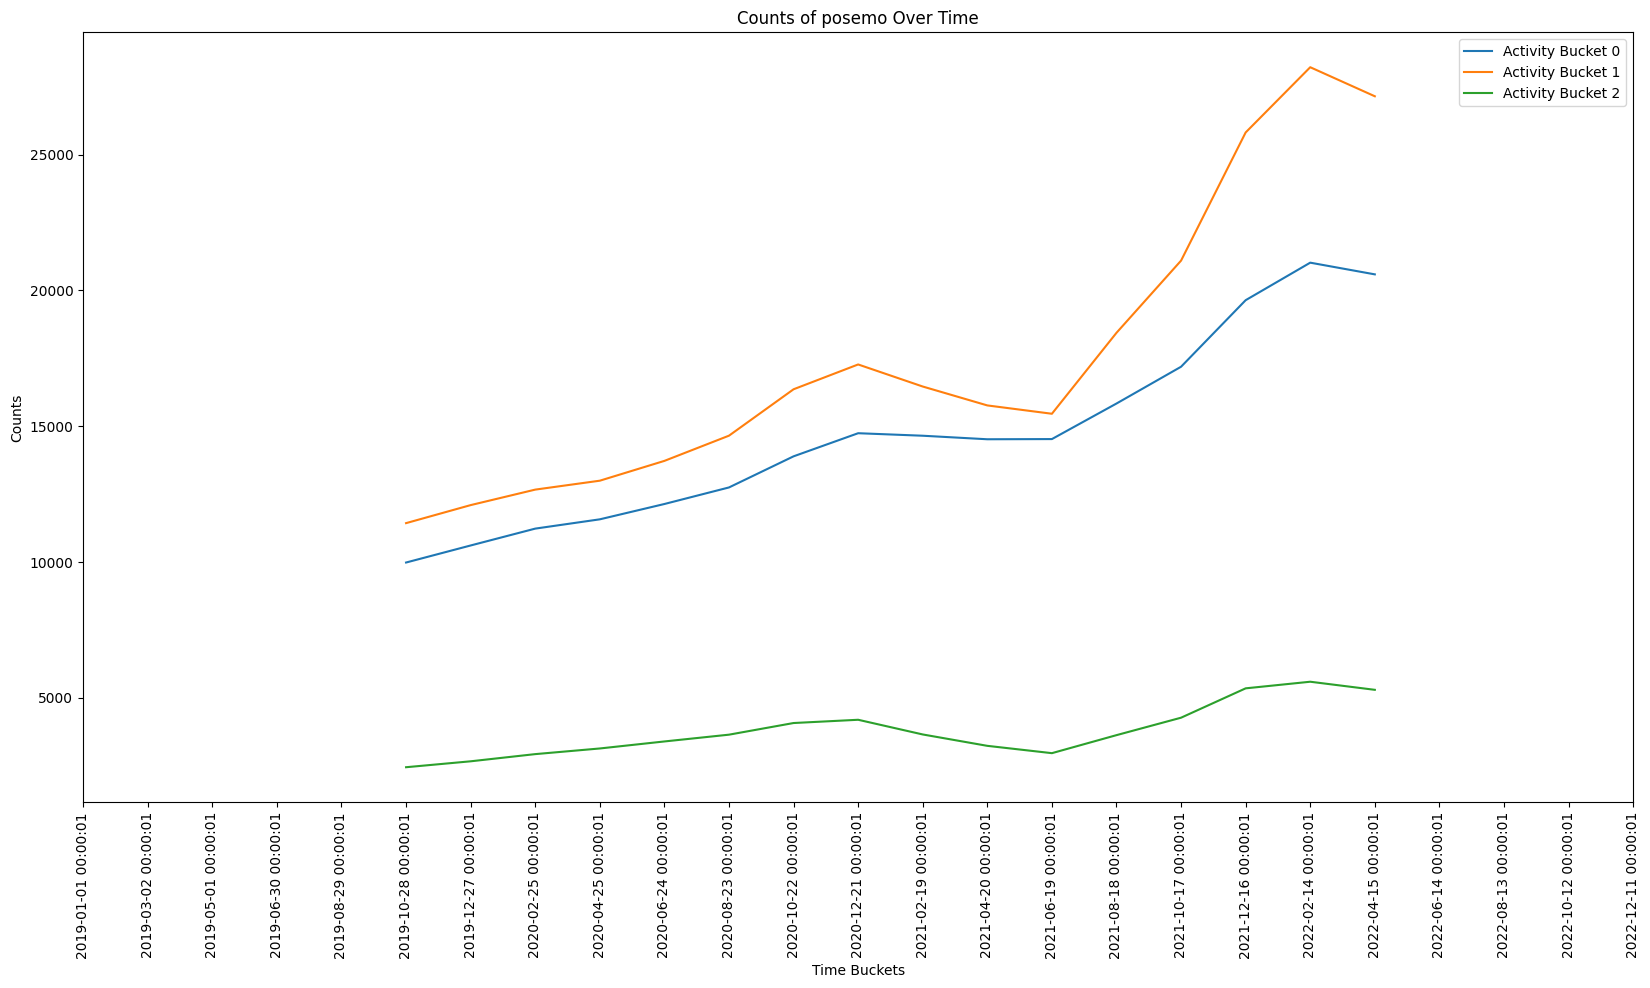

In [35]:
# Read LIWC_category_dict_normalised as a literal string from a file
with open(f'text_liwc_dimensions/{os.path.basename(data_file_path[:-5])}_LIWC_normalised.json', 'r') as f:
    # Read the file as a string
    LIWC_category_dict_normalised = f.read()

    # Convert the string to a dictionary
    LIWC_category_dict_normalised = eval(LIWC_category_dict_normalised)

# Import datetime to convert the time_buckets to human readable labels
from datetime import datetime

# Select the LIWC category to graph
category = 'posemo'

# Extract the data from the dictionary
LIWC_by_bucket = LIWC_category_dict_normalised[category]

print(LIWC_by_bucket)

# Set plot size
plt.figure(figsize=(20, 10))

# Graph all activity buckets in different colours
for i in range(3):
    # Get a moving average of the data LIWC_category_dict_normalised
    moving_average = np.convolve(LIWC_by_bucket[i], np.ones(10), 'valid') / 10

    # Plot the moving average
    plt.plot(time_buckets[5:-5], moving_average[:-1], label=f'Activity Bucket {i}')


# Give time buckets human readable labels
plt.xticks(time_buckets[:-1], [datetime.utcfromtimestamp(time_bucket).strftime('%Y-%m-%d %H:%M:%S') for time_bucket in time_buckets[:-1]], rotation=90)

# Add labels and title
plt.xlabel('Time Buckets')
plt.ylabel('Counts')
plt.title(f'Counts of {category} Over Time')

# Add a legend
plt.legend()

# Display the graph
plt.show()